Gini 계수

<function matplotlib.pyplot.show>

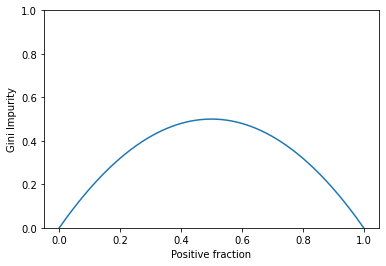

In [1]:
import matplotlib.pyplot as plt
import numpy as np

pos_fraction = np.linspace(0.00, 1.00, 1000)
gini = 1- ( pos_fraction**2 + (1-pos_fraction)**2 )

plt.plot(pos_fraction, gini)
plt.ylim(0,1)
plt.xlabel('Positive fraction')
plt.ylabel("Gini Impurity")
plt.show

In [2]:
def gini_impurity(labels):
  if not labels:
    return 0
  
  counts = np.unique(labels, return_counts = True)[1]
  fractions = counts/float(len(labels))

  return 1 - np.sum(fractions**2)

In [3]:
print(gini_impurity([1,1,1,0,0]))

0.48


Entropy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


<function matplotlib.pyplot.show>

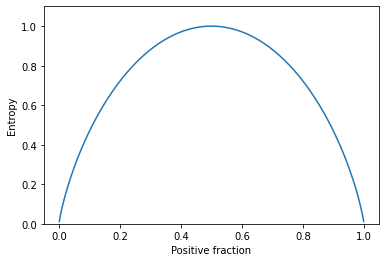

In [4]:
pos_fraction = np.linspace(0.00, 1.00, 1000)
entropy = -( pos_fraction*np.log2(pos_fraction) + (1-pos_fraction)*np.log2(1-pos_fraction) )

plt.plot(pos_fraction, entropy)
plt.ylim(0,1.1)
plt.xlabel('Positive fraction')
plt.ylabel("Entropy")
plt.show

In [5]:
def entropy(labels):
  if not labels:
    return 0
  
  counts = np.unique(labels, return_counts = True)[1]
  fractions = counts/float(len(labels))

  return -np.sum(fractions * np.log2(fractions))

In [6]:
print(entropy([1,1,1,0,0]))

0.9709505944546686


AD Click-Through Rate (CTR) Prediction

In [8]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/ML&DM/Mechine_Learning/ctr_data_20000.csv')
data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [9]:
data = data.drop(['id', 'hour','device_id', 'device_ip'], axis =1) # 쓸모없는 칼럼들 삭제

In [12]:
from sklearn.feature_extraction import DictVectorizer # feature들을 one-hot encoding으로 바꿔줌

data_x = data.loc[:, data.columns != 'click'].astype('str')
data_y = data.loc[:, data.columns == 'click'].astype('int').values.ravel()

train_x, test_x = data_x[0:15000], data_x[15000:]
train_y, test_y = data_y[0:15000], data_y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse=False)
onehot_train_x = dict_one_hot_encoder.fit_transform(train_x.to_dict('records'))
onehot_test_x = dict_one_hot_encoder.transform(test_x.to_dict('records'))

print(train_x.shape)
print(onehot_train_x.shape)

(15000, 19)
(15000, 3244)


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3,10,None]}
decision_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 30)
grid_search = GridSearchCV(decision_tree, parameters, n_jobs= -1, cv=3, scoring='roc_auc')
grid_search.fit(onehot_train_x, train_y)

print(grid_search.best_params_)

{'max_depth': 10}


In [15]:
decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(onehot_test_x)[:,1]

from sklearn.metrics import roc_auc_score
print("The ROC AUC on testing set is", roc_auc_score(test_y, pos_prob))

The ROC AUC on testing set is 0.6867329993739317


Random Forest

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth' : [3,10,None]}
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)

grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

grid_search.fit(onehot_train_x, train_y)
print(grid_search.best_params_)

{'max_depth': None}


In [21]:
random_forest_best = grid_search.best_estimator_
pos_prob = random_forest_best.predict_proba(onehot_test_x)[:,1]
print("The ROC AUC on testing set is {0:3f}".format(roc_auc_score(test_y, pos_prob)))

The ROC AUC on testing set is 0.708305


AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30, max_depth=3)
clf = AdaBoostClassifier(base_estimator = decision_tree, n_estimators=50, learning_rate=1)
# base_estimator : Boost에 사용할 학습 모델
# n_estimator : 모델을 최대 몇개까지 이어 붙일 것인지
# learning_rate : 뒤에 붙는 모델일수록 전체 결과에 작은 영향을 주도록 하는 변수(1이면 모든 모델 동일동일)
clf.fit(onehot_train_x, train_y)
pos_prob = clf.predict_proba(onehot_test_x)[:,1]
print("The ROC AUC on testing set is {0:3f}".format(roc_auc_score(test_y, pos_prob)))

The ROC AUC on testing set is 0.699037
